<a href="https://colab.research.google.com/github/nahbos/AUT-Advanced-Information-Retrieval/blob/main/Ex03/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sobhan Moradian Daghigh

- 2-3-2023

### Ex-03: Recommender System

In [1]:
import numpy as np
import pandas as pd
import json
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from bs4 import BeautifulSoup


# from gensim.models import TfidfModel
# from gensim.corpora import Dictionary
# from gensim.utils import simple_preprocess
# from gensim.parsing.preprocessing import remove_stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from collections import Counter
# import random
# import pickle
# from PIL import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part One. 
* Data Loading

In [3]:
with open('./drive/MyDrive/data.json') as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

train = pd.DataFrame(jsonObject['train'])
val   = pd.DataFrame(jsonObject['val'])
test  = pd.DataFrame(jsonObject['test'])

In [4]:
train.head()

,business_id,user_id,rating,review_text,pics,history_reviews
0,60567465d335d0abfb415b26,101074926318992653684,4,The tang of the tomato sauce is outstanding. A...,[https://lh5.googleusercontent.com/p/AF1QipM-2...,[[101074926318992653684_6056272797d555cc6fb0d1...
1,6050fa9f5b4ccec8d5cae994,117065749986299237881,5,Chicken and waffles were really good!,[https://lh5.googleusercontent.com/p/AF1QipMpf...,[[117065749986299237881_605206f8d8c08f462b93e8...
2,604be10877e81aaed3cc9a1e,106700937793048450809,4,The appetizer of colossal shrimp was very good...,[https://lh5.googleusercontent.com/p/AF1QipMNn...,[[106700937793048450809_6044300b27f39b7b5d1dbf...
3,60411e017cd8bf130362365a,101643045857250355161,5,The fish tacos here omg! The salad was great ...,[https://lh5.googleusercontent.com/p/AF1QipM-a...,[[101643045857250355161_604fbdd099686c10168c91...
4,604139dd7cd8bf1303624208,109802745326785766951,4,"Ribs are great, as are the mac and cheese, fri...",[https://lh5.googleusercontent.com/p/AF1QipNVy...,[[109802745326785766951_60524fa9f09a4ffff042f9...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87013 entries, 0 to 87012
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      87013 non-null  object
 1   user_id          87013 non-null  object
 2   rating           87013 non-null  int64 
 3   review_text      87013 non-null  object
 4   pics             87013 non-null  object
 5   history_reviews  87013 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.0+ MB


In [6]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10860 entries, 0 to 10859
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      10860 non-null  object
 1   user_id          10860 non-null  object
 2   rating           10860 non-null  int64 
 3   review_text      10860 non-null  object
 4   pics             10860 non-null  object
 5   history_reviews  10860 non-null  object
dtypes: int64(1), object(5)
memory usage: 509.2+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11015 entries, 0 to 11014
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      11015 non-null  object
 1   user_id          11015 non-null  object
 2   rating           11015 non-null  int64 
 3   review_text      11015 non-null  object
 4   pics             11015 non-null  object
 5   history_reviews  11015 non-null  object
dtypes: int64(1), object(5)
memory usage: 516.5+ KB


## Preprocess

In [8]:
def preprocess(q):
   
    # Lowercase
    q = str(q).lower().strip()      
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953

    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "was'nt": "was not",
    "were'nt": "were not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Removing Punctuation
    q = "".join([char for char in q if char not in string.punctuation])
    
    # Word Tokenization
    q = word_tokenize(q)
    
    # Stopword Filtering
    stop_words = stopwords.words('english')
    [stop_words.remove(x) for x in ['not', 'very']]
    q = [word for word in q if word not in stop_words]
    
    # Stemming
    porter = PorterStemmer()
    q = [porter.stem(word) for word in q]
    q = ' '.join(q)
    
    return q

In [9]:
preprocess('Hi, no no no the food was awful')

'hi food aw'

In [10]:
preprocess('The best Kentaki ever, thank you')

'best kentaki ever thank'

In [11]:
def text_preprocessor(dataset):
    org = dataset.copy()
    dataset['review_text'] = dataset['review_text'].apply(preprocess)
    
    for row in tqdm(dataset.iterrows()):
        for item in row[1]['history_reviews']:
          item[1] = preprocess(item[1])

    return org, dataset

In [12]:
train_org, train = text_preprocessor(train)
val_org, val = text_preprocessor(val)
test_org, test = text_preprocessor(test)

87013it [04:20, 334.65it/s]
10860it [00:29, 373.63it/s]
11015it [00:33, 324.96it/s]


In [13]:
def obj2int(data):
    x1 = list(set(data.business_id))
    x2 = list(set(data.user_id))

    dic1 = dict(zip(x1, list(range(1, len(x1) + 1))))
    dic2 = dict(zip(x2, list(range(1, len(x2) + 1))))

    data['business_id'] = [dic1[v] for v in data.business_id]
    data['user_id'] = [dic2[v] for v in data.user_id]
    return data

In [14]:
merged = obj2int(pd.concat([train, val, test], ignore_index=True))

train = merged.iloc[:len(train), :]
val = merged.iloc[len(train):len(train) + len(val), :]
test = merged.iloc[-len(test):, :]

In [15]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### Split test dataset into some subsets including the users who rated more than n restaurants.

In [16]:
groups = test.groupby(by='user_id')
groups.first()

,business_id,rating,review_text,pics,history_reviews
user_id,,,,,
2,28461,5,contempl tri doughnut place start drive doughn...,[https://lh5.googleusercontent.com/p/AF1QipNqN...,[[103250724592800235316_605122799c93e55e75b724...
4,13996,5,got two slider jalapeno popper whoa jalapeno r...,[https://lh5.googleusercontent.com/p/AF1QipMmp...,[[109345222962964517381_604f36a48ba95eba01a00c...
6,28779,4,thanksgiv meal school hous great,[https://lh5.googleusercontent.com/p/AF1QipNan...,[[116043428890309046796_60421dd92e57ebdea29c82...
18,16622,5,great pep garlic slice,[https://lh5.googleusercontent.com/p/AF1QipNri...,[[117471268248068019066_6040aa539d953d1f97fa18...
20,6455,5,fish chip delici french onion soup savori chee...,[https://lh5.googleusercontent.com/p/AF1QipN-A...,[[108358278400931015432_6050d88b4cd354c57204c1...
...,...,...,...,...,...
36949,20605,4,order steak crab cake jambalaya devil egg ahi ...,[https://lh5.googleusercontent.com/p/AF1QipNeu...,[[108234948900465599587_6043c21bad733fba1bcfe1...
36961,30085,5,great hawaiian burger,[https://lh5.googleusercontent.com/p/AF1QipOY2...,[[106489790969025519864_605061eb9755094ba8abeb...
36964,26097,5,pictur 1 two meat plate pull pork rib mac chee...,[https://lh5.googleusercontent.com/p/AF1QipOKu...,[[115539324057246278754_604a1a4c1ec03878d66c81...


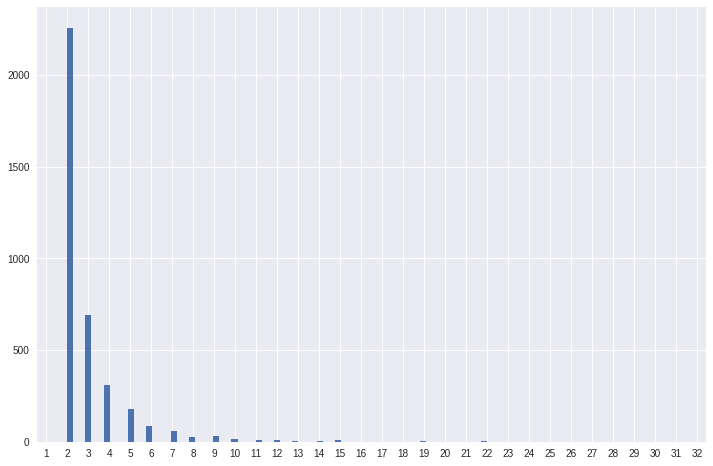

In [17]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(12, 8))
    plt.hist([len(pdf) for grp, pdf in groups], bins=100)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

In [205]:
def user_extractor(dataset, limit=3):
    groups = dataset.groupby(by='user_id')
    for grp, pdf in groups:
        if len(pdf) < limit:
            dataset = dataset[dataset.user_id != grp]
    dataset.reset_index(drop=True, inplace=True)
    return dataset

In [206]:
test_includes_2  = user_extractor(dataset=test, limit=2)
test_includes_3  = user_extractor(dataset=test, limit=3)
test_includes_4  = user_extractor(dataset=test, limit=4)
test_includes_5  = user_extractor(dataset=test, limit=5)
test_more_than_5 = user_extractor(dataset=test, limit=6)

In [207]:
[len(ele) for ele in [test_includes_2, test_includes_3, test_includes_4, test_includes_5, test_more_than_5]]

[11015, 6501, 4431, 3187, 2302]

**Ok, Everything looks right ))**

# Part Two.
* Evaluation Metrics

### Precision @ k

In [134]:
# Precision @ k
def precision_at_k(ref, pred, k=5):
    cnt = [1 if a == b else 0 for a, b in zip(ref, pred)]
    return sum(cnt[:k]) / k

### Recall @ k

In [175]:
# Recall @ k
def recall_at_k(ref, pred, k=5):
    cnt = [1 if a == b else 0 for a, b in zip(ref, pred)]
    return [(sum(cnt[:k]) / sum(ref[:k])) if sum(ref[:k]) != 0 else 0]

## Evaluate

In [189]:
def evaluate(dataset, predictions):
    precisions = []
    recalls = []
    groups = dataset.groupby(by='user_id')
    for grp, pdf in groups:
        preds = np.array(predictions)[[ele for ele in pdf.index]].reshape(-1)
        indices = np.argsort(preds)[::-1]

        preds_binary = [1 if ele >= 0.5 else 0 for ele in preds[indices]]
        ref_binary = [1 if ele >= 3 else 0 for ele in np.array(pdf['rating'])[indices]]
        
        precisions.append(precision_at_k(ref=ref_binary, pred=preds_binary, k=5))
        recalls.append(recall_at_k(ref=ref_binary, pred=preds_binary, k=5))
    
    return precisions, recalls

In [209]:
def evaluator(model, dataset, kind='advanced'):
    features = [dataset.user_id, dataset.business_id]
    if kind == 'advanced':
        test_user_avg = get_avg(dataset, 'user_id')
        test_restaurant_avg = get_avg(dataset, 'business_id')
        features.append(test_user_avg)
        features.append(test_restaurant_avg)
    
    predictions = model.predict(features)
    precisions, recalls = evaluate(dataset, predictions)
    print('Precision at 5:  {:.2f}'.format(np.average(precisions)))
    print('Recall    at 5:  {:.2f}'.format(np.average(recalls)))

# Part Three.
Neural network Recommender System

In [22]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

In [23]:
n_items = len(train.business_id.unique()) + len(val.business_id.unique()) + len(test.business_id.unique())
n_users = len(train.user_id.unique()) + len(val.user_id.unique()) + len(test.user_id.unique())
max_rate = 5

In [24]:
n_items, n_users

(43611, 36996)

In [25]:
THRESHOLD = 3
def get_binary(arr):
    return np.array([1 if x >= THRESHOLD else 0 for x in arr])

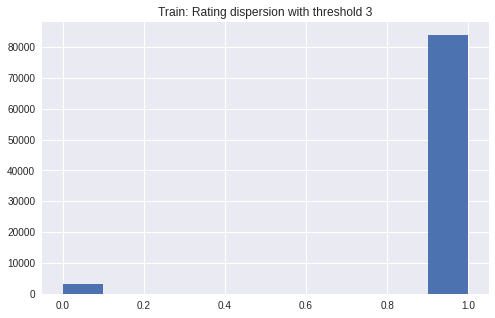

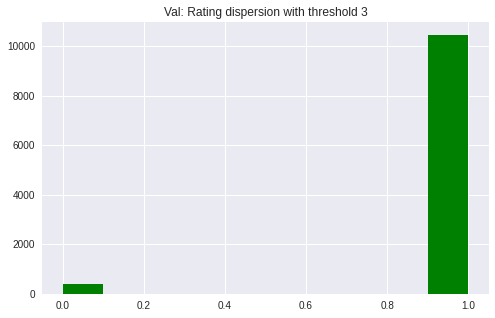

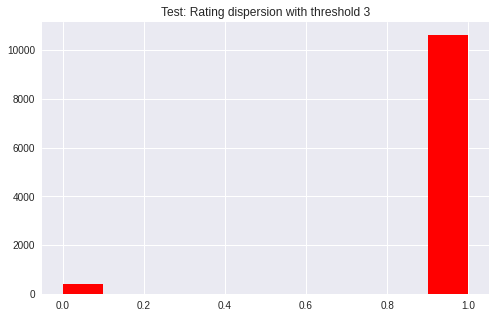

In [26]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(8, 5))
    plt.hist(get_binary(train.rating))
    plt.title('Train: Rating dispersion with threshold {}'.format(THRESHOLD))
    plt.show()

with plt.style.context('seaborn'):
    plt.figure(figsize=(8, 5))
    plt.hist(get_binary(val.rating), color='green')
    plt.title('Val: Rating dispersion with threshold {}'.format(THRESHOLD))
    plt.show()

with plt.style.context('seaborn'):
    plt.figure(figsize=(8, 5))
    plt.hist(get_binary(test.rating), color='red')
    plt.title('Test: Rating dispersion with threshold {}'.format(THRESHOLD))
    plt.show()

In [27]:
# creating restaurant embedding path
restaurant_input = Input(shape=[1], name="Restaurant-Input")
restaurant_embedding = Embedding(n_items + 1, 16, name="Restaurant-Embedding")(restaurant_input)
restaurant_vec = Flatten(name="Flatten-Restaurant")(restaurant_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 16, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([restaurant_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1, activation='sigmoid')(fc2)

# Create model and compile it
model = Model([user_input, restaurant_input], out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history = model.fit([train.user_id, train.business_id], get_binary(train.rating), 
                    epochs=5, 
                    validation_data=([val.user_id, val.business_id], get_binary(val.rating)), 
                    verbose=1)

Epoch 1/5
2720/2720 [==============================] - 22s 8ms/step - loss: 0.1587 - accuracy: 0.9643 - val_loss: 0.1664 - val_accuracy: 0.9622
Epoch 2/5
2720/2720 [==============================] - 21s 8ms/step - loss: 0.0794 - accuracy: 0.9714 - val_loss: 0.4084 - val_accuracy: 0.7858
Epoch 3/5
2720/2720 [==============================] - 23s 9ms/step - loss: 0.0339 - accuracy: 0.9870 - val_loss: 0.4887 - val_accuracy: 0.7571
Epoch 4/5
2720/2720 [==============================] - 23s 8ms/step - loss: 0.0173 - accuracy: 0.9927 - val_loss: 0.7825 - val_accuracy: 0.7213
Epoch 5/5
2720/2720 [==============================] - 22s 8ms/step - loss: 0.0090 - accuracy: 0.9960 - val_loss: 0.8490 - val_accuracy: 0.7392


In [29]:
model.evaluate([test.user_id, test.business_id], get_binary(test.rating))

345/345 [==============================] - 0s 1ms/step - loss: 0.8230 - accuracy: 0.7404


[0.822998046875, 0.740354061126709]

In [30]:
predictions = model.predict([test.user_id, test.business_id])

345/345 [==============================] - 1s 1ms/step


In [31]:
[print('Pred: {} - GT: {}'.format([0 if predictions[i] < 0.5 else 1], get_binary(test.rating)[i])) for i in range(60, 80)]
print('Done')

Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [0] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [0] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 0
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [0] - GT: 0
Pred: [1] - GT: 1
Pred: [1] - GT: 0
Pred: [0] - GT: 1
Pred: [1] - GT: 1
Pred: [0] - GT: 1
Pred: [0] - GT: 1
Pred: [1] - GT: 1
Done


In [32]:
preds = [0 if predictions[i] < 0.5 else 1 for i in range(len(predictions))]
temp = []
for i, ele in enumerate(get_binary(test.rating)):
    if ele == 0:
        temp.append(preds[i])

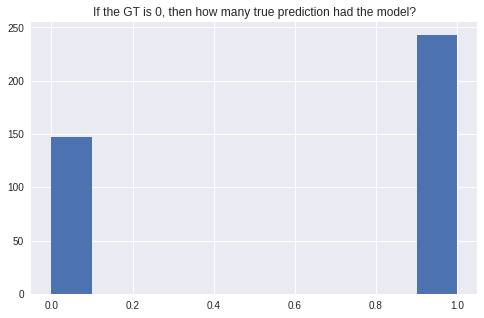

In [33]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(8, 5))
    plt.hist(temp)
    plt.title('If the GT is 0, then how many true prediction had the model?')
    plt.show()

This is not good!

THIS IS NOT GOOD!

In [217]:
evaluator(model=model, dataset=test_includes_2, kind='Normal')

345/345 [==============================] - 0s 1ms/step
Precision at 5:  0.41
Recall    at 5:  0.78


In [218]:
evaluator(model=model, dataset=test_includes_3, kind='Normal')

204/204 [==============================] - 0s 1ms/step
Precision at 5:  0.60
Recall    at 5:  0.81


In [219]:
evaluator(model=model, dataset=test_includes_4, kind='Normal')

139/139 [==============================] - 0s 1ms/step
Precision at 5:  0.74
Recall    at 5:  0.85


In [220]:
evaluator(model=model, dataset=test_includes_5, kind='Normal')

100/100 [==============================] - 0s 1ms/step
Precision at 5:  0.84
Recall    at 5:  0.87


In [221]:
evaluator(model=model, dataset=test_more_than_5, kind='Normal')

72/72 [==============================] - 0s 1ms/step
Precision at 5:  0.92
Recall    at 5:  0.94


# Part Four.
Ok lets use a trick ))

In [36]:
def get_avg(dataset, col):
    avgs = []
    temp = {}
    groups = dataset.groupby(by=col)
    for grp, pdf in groups:
        temp[grp] = np.average(pdf['rating'])
    for row in dataset.iterrows():
        avgs.append(temp[row[1][col]])
    return np.array(avgs)

In [37]:
# creating restaurant embedding path
restaurant_input = Input(shape=[1], name="Restaurant-Input")
restaurant_embedding = Embedding(n_items + 1, 16, name="Restaurant-Embedding")(restaurant_input)
restaurant_vec = Flatten(name="Flatten-Restaurant")(restaurant_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 16, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# creating restaurant average rates embedding path
restaurant_average_rates_input = Input(shape=[1], name="Restaurant-Avg-Rates-Input")
restaurant_average_rates_embedding = Embedding(max_rate + 1, 16, name="Restaurant-Avg-Rates-Embedding")(restaurant_average_rates_input)
restaurant_average_rates_vec = Flatten(name="Flatten-Restaurant-Avg-Rates")(restaurant_average_rates_embedding)

# creating user average rates embedding path
user_average_rates_input = Input(shape=[1], name="User-Avg-Rates-Input")
user_average_rates_embedding = Embedding(max_rate + 1, 16, name="User-Avg-Rates-Embedding")(user_average_rates_input)
user_average_rates_vec = Flatten(name="Flatten-User-Avg-Rates")(user_average_rates_embedding)

# concatenate features
conc = Concatenate()([restaurant_vec, user_vec, restaurant_average_rates_vec, user_average_rates_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1, activation='sigmoid')(fc2)

# Create model and compile it
advanced_model = Model([user_input, restaurant_input, user_average_rates_input, restaurant_average_rates_input], out)
advanced_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
train_user_avg = get_avg(train, 'user_id')
train_restaurant_avg = get_avg(train, 'business_id')
val_user_avg = get_avg(val, 'user_id')
val_restaurant_avg = get_avg(val, 'business_id')
test_user_avg = get_avg(test, 'user_id')
test_restaurant_avg = get_avg(test, 'business_id')

In [39]:
history = advanced_model.fit([train.user_id, train.business_id, train_user_avg, train_restaurant_avg], get_binary(train.rating), 
                        epochs=5, 
                        validation_data=([val.user_id, val.business_id, val_user_avg, val_restaurant_avg], get_binary(val.rating)), 
                        verbose=1)

Epoch 1/5
2720/2720 [==============================] - 25s 9ms/step - loss: 0.0801 - accuracy: 0.9742 - val_loss: 0.0526 - val_accuracy: 0.9848
Epoch 2/5
2720/2720 [==============================] - 26s 10ms/step - loss: 0.0602 - accuracy: 0.9789 - val_loss: 0.0613 - val_accuracy: 0.9845
Epoch 3/5
2720/2720 [==============================] - 24s 9ms/step - loss: 0.0267 - accuracy: 0.9895 - val_loss: 0.1113 - val_accuracy: 0.9524
Epoch 4/5
2720/2720 [==============================] - 23s 9ms/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 0.1676 - val_accuracy: 0.9144
Epoch 5/5
2720/2720 [==============================] - 24s 9ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.2114 - val_accuracy: 0.8926


In [40]:
advanced_model.evaluate([test.user_id, test.business_id, test_user_avg, test_restaurant_avg], get_binary(test.rating))

345/345 [==============================] - 0s 1ms/step - loss: 0.1985 - accuracy: 0.8935


[0.1985168755054474, 0.8935088515281677]

In [41]:
advanced_predictions = advanced_model.predict([test.user_id, test.business_id, test_user_avg, test_restaurant_avg])

345/345 [==============================] - 1s 1ms/step


In [42]:
[print('Pred: {} - GT: {}'.format([0 if advanced_predictions[i] < 0.5 else 1], get_binary(test.rating)[i])) for i in range(60, 80)]
print('Done')

Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [0] - GT: 0
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [0] - GT: 0
Pred: [1] - GT: 1
Pred: [0] - GT: 0
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Pred: [1] - GT: 1
Done


In [43]:
adv_preds = [0 if advanced_predictions[i] < 0.5 else 1 for i in range(len(advanced_predictions))]
adv_temp = []
for i, ele in enumerate(get_binary(test.rating)):
    if ele == 0:
        adv_temp.append(adv_preds[i])

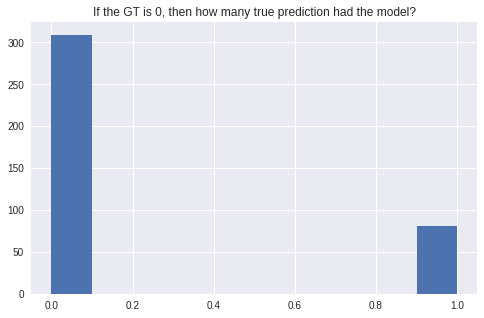

In [44]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(8, 5))
    plt.hist(adv_temp)
    plt.title('If the GT is 0, then how many true prediction had the model?')
    plt.show()

Wow )) Gr8

In [211]:
evaluator(model=advanced_model, dataset=test_includes_2)

345/345 [==============================] - 0s 1ms/step
Precision at 5:  0.49
Recall    at 5:  0.95


In [212]:
evaluator(model=advanced_model, dataset=test_includes_3)

204/204 [==============================] - 0s 1ms/step
Precision at 5:  0.70
Recall    at 5:  0.95


In [213]:
evaluator(model=advanced_model, dataset=test_includes_4)

139/139 [==============================] - 0s 2ms/step
Precision at 5:  0.84
Recall    at 5:  0.95


In [214]:
evaluator(model=advanced_model, dataset=test_includes_5)

100/100 [==============================] - 0s 1ms/step
Precision at 5:  0.93
Recall    at 5:  0.96


In [215]:
evaluator(model=advanced_model, dataset=test_more_than_5)

72/72 [==============================] - 0s 985us/step
Precision at 5:  0.96
Recall    at 5:  0.97


# Finito